In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
DIR = 'dataset'
CLASSES = ['with_mask', 'without_mask']

# Image Augmentation

In [3]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.2, 0.8),
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    validation_split=0.3, 
    dtype=None
)

In [4]:
train_gen = image_gen.flow_from_directory(
    DIR,
    target_size=(224, 224),
    batch_size=64,
    subset='training',
    shuffle=True,
    classes=CLASSES
)

Found 5288 images belonging to 2 classes.


In [5]:
validation_gen = image_gen.flow_from_directory(
    DIR,
    target_size=(224, 224),
    batch_size=64,
    subset='validation',
    shuffle=True,
    classes=CLASSES
)

Found 2265 images belonging to 2 classes.


**Lets see augmented images**

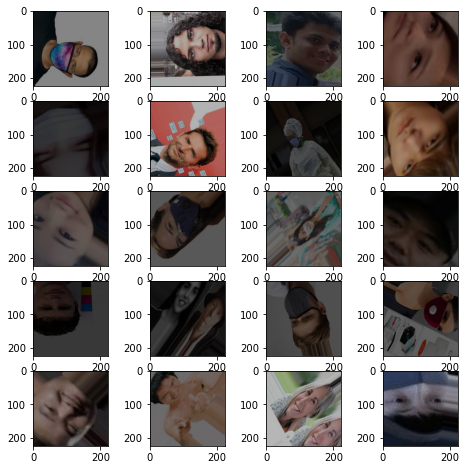

In [6]:
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img, label = train_gen.next()
    fig.add_subplot(rows, columns, i)
    plt.imshow(img[0])
    img.size
plt.show()

C:\Users\ACER\anaconda3\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


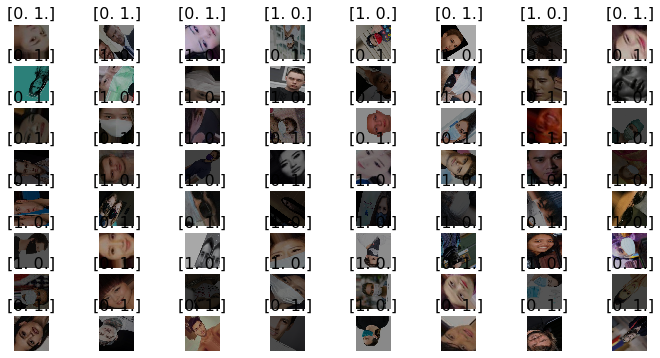

In [7]:
import numpy as np

# plot function, used to plot images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=8, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims= np.array(ims * 255).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

imgs, labels = next(train_gen)

# we plot these samples of images and their labels 1 batch at a time.
plots(imgs, titles=labels)

## Building Fine-tuned VGG16 model

In [8]:
from tensorflow.keras import applications

In [9]:
vgg16_model = applications.vgg16.VGG16()

In [10]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

#### Not a Sequential model so we need to transform the model into Sequential model.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout

#### We need to take off the last Dense layer because default state it classifies 1000 categories

In [13]:
model = Sequential()

for layer in vgg16_model.layers[: -1]: # add layers axcept lat dense layer[: -1]
    model.add(layer) # add each layer in vgg16 to Sequential model

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

### Add last Dense layer for binary classification

In [15]:
from tensorflow.keras.layers import Dense

In [16]:
model.add(Dense(2, activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

### Training

In [18]:
from tensorflow.keras.optimizers import Adam

In [19]:
model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [20]:
from tensorflow.keras import callbacks

In [21]:
# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

In [22]:
# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopping = callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)

In [23]:
hist = model.fit(
    train_gen,
    validation_data=validation_gen,
    epochs=10,
    verbose=1,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/10


ResourceExhaustedError: in user code:

    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:799 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:530 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:636 apply_gradients
        self._create_all_weights(var_list)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:823 _create_all_weights
        self._create_slots(var_list)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\adam.py:126 _create_slots
        self.add_slot(var, 'v')
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:909 add_slot
        weight = tf_variables.Variable(
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\variables.py:262 __call__
        return cls._variable_v2_call(*args, **kwargs)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\variables.py:244 _variable_v2_call
        return previous_getter(
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3523 creator
        return next_creator(**kwargs)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3523 creator
        return next_creator(**kwargs)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3523 creator
        return next_creator(**kwargs)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py:750 variable_capturing_scope
        v = UnliftedInitializerVariable(
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\variables.py:264 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py:293 __init__
        initial_value = initial_value()
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\initializers\initializers_v2.py:151 __call__
        return array_ops.zeros(shape, dtype)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\array_ops.py:2911 wrapped
        tensor = fun(*args, **kwargs)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\array_ops.py:2972 zeros
        output = fill(shape, constant(zero, dtype=dtype), name=name)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\array_ops.py:239 fill
        result = gen_array_ops.fill(dims, value, name=name)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\gen_array_ops.py:3367 fill
        _ops.raise_from_not_ok_status(e, name)
    C:\Users\ACER\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py:6897 raise_from_not_ok_status
        six.raise_from(core._status_to_exception(e.code, message), None)
    <string>:3 raise_from
        

    ResourceExhaustedError: OOM when allocating tensor with shape[25088,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill]


# Learning and Loss curves

In [ ]:
import matplotlib.pyplot as plt

def gen_graph(history, title):
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  plt.show()

In [ ]:
gen_graph(hist, 'Face Mask Detection')

### Save Model

In [ ]:
model.save('saved_model/vgg_model.h5')

### Predictions

In [ ]:
img_file ='w_m_2.jpg'
def get_processed_input_img(image_path, size=224):
  test_img =  cv2.imread(image_path) 
  test_img = cv2.resize(test_img, dsize=(size, size), interpolation=cv2.INTER_AREA)
 
  test_img = test_img.reshape((1, size, size, 3)).astype(np.float32)
  
  return test_img/255

In [ ]:
image = get_processed_input_img(img_file)

In [ ]:
pred = model.predict(image)
print(pred)

In [ ]:
best_2 = (-pred).argsort()[0]

[0.5 0.7]
[1 0]

In [ ]:
print(best_2)

In [ ]:
print([CLASSES[i] for i in best_2])